In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
import pyPIPS.polarimetric as dualpol
#from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from scipy import interpolate
from metpy.plots import StationPlot
import metpy.calc as mpcalc
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
from scipy.signal import medfilt2d
import pyart
import cartopy.crs as ccrs
%matplotlib inline
import warnings;
warnings.filterwarnings('ignore')


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Function definitions
def readESC(sounding_path, interpnan=True, handle=False):
    """
    Reads in a sounding in ESC format from a provided file path or handle (can be a StringIO object or an open
    file handle)
    """
    col_names = ['pressure','temperature','dewpoint','u_wind','v_wind','speed','direction','height',
                 'Qp_code','Qt_code','Qrh_code','Qu_code','Qv_code']
    # First read the file and extract the field widths from the 14th header line
    if not handle:
        f = open(sounding_path, 'r')
    else:
        f = sounding_path

    # Read in the header and extract some metadata from it
    dummy = f.readline()
    dummy = f.readline()
    header2 = f.readline().strip().split(':')
    # Read next header line and extract station id and wmo number from it (if it exists)
    staid_wmo_str = header2[1]
    if ' / ' in staid_wmo_str:
        staid_wmo = staid_wmo_str.strip().split(' / ')
        staid = staid_wmo[0][1:4]
        wmo = int(staid_wmo[1])
    else:
        if '. ' in staid_wmo_str:
            staid = staid_wmo_str.replace('. ', '').strip()[:4]
        else:
            staid = staid_wmo_str.strip()[:4]
            staid = staid.replace(" ", "")
        wmo = 99999
    print(staid)
    # Read the next header line and extract the location information from it
    header3 = f.readline().strip().split(':')
    location = header3[1].strip().split(',')
    print(location)
    lon = np.float(location[2])
    lat = np.float(location[3])
    elev = np.float(location[4])
    # Read the next header line and extract the time information from it
    header4 = f.readline().strip()[31:].lstrip()   
    sounding_datetime = datetime.strptime(header4, '%Y, %m, %d, %H:%M:%S')
    
    # Now read and dump the rest of the header
    for i in range(9):
        f.readline()
    
    # Except for the last header line, which is used to determine the widths of the fields
    line = f.readline().strip().split()
    fw = [len(field)+1 for field in line]

    # Now read the file into the dataframe, using the extracted field widths
    df = pd.read_fwf(f, usecols=[1, 2, 3, 5, 6, 7, 8, 14, 15, 16, 17, 18, 19],
                     names=col_names, na_values=['99999.0', '9999.0', '999.0'], widths=fw)
    
    # For some reason, need to convert all the columns to floating point here, as some get interpreted as strings
    # when they shouldn't be...
    # print(df['pressure'], df['temperature'])
    for column in df.columns:
        df[column] = df[column].astype(np.float)
    
    # Drop rows where height or pressure is NaN. TODO: Can't remember why I have to use reset_index(drop=True). 
    # Figure this out.
    df = df.dropna(subset=('height', 'pressure')).reset_index(drop=True)
    # Set the height as the index so we can use it as weights to interpolate other columns across NaN
    df = df.set_index('height')
    df['height'] = df.index
    
    if interpnan:
        # First convert direction and speed to u, v components
        df['u'], df['v'] = mpcalc.wind_components(df['speed'].values*units('m/s'),
                                                      df['direction'].values*units.degrees)
        # Now interpolate
        df = df.interpolate(method='values')
        # Finally recompute direction and speed from u, v components
        df['speed'] = mpcalc.wind_speed(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
        df['direction'] = mpcalc.wind_direction(df['u'].values*units('m/s'), df['v'].values*units('m/s'))
    else:
        # Drop any rows with all NaN values for T, Td, winds
        df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed',
                               'u_wind', 'v_wind'), how='all').reset_index(drop=True)
    
    df = df[(df.Qp_code == 1.0) & (df.Qt_code == 1.0) & (df.Qrh_code == 1.0) & (df.Qu_code == 1.0) & 
            (df.Qv_code == 1.0)]

    nlines = df.count()['pressure']
    
    if not handle:
        f.close()
    
    snd_metadata = {
        'sounding_datetime': sounding_datetime,
        'lat': lat,
        'lon': lon,
        'selev': elev,
        'staid': staid,
        'wmo': wmo,
        'nlevs': nlines,
        'staid_long': staid_wmo_str
    }
    
    return snd_metadata, df


def roundPartial(value, resolution, decimals=4):
    return np.around(np.round(value / resolution) * resolution, decimals=decimals)


def rain_Brandes(D):
    """Given a range of diameters D, compute rain fall speed curve, a quartic polynomial
       fit after Brandes et al. (2002)."""
    
    D_mm=D*1000. # get it to (mm)
    
    Vtr = -0.1021 + 4.932*D_mm - 0.9551*D_mm**2. + 0.07934*D_mm**3. - 0.002362*D_mm**4.
    
    return Vtr


def cal_xf(usm,vsm,vt,H):
    """Computes final horizontal position (relative to starting position) of a raindrop
       falling through a layer H with terminal velocity vt and storm releative mean wind
       given by (usm,vsm)."""
    
    xf = (H/vt)*usm
    yf = (H/vt)*vsm
    
    return xf,yf


def mtokm(val,pos):
    """Convert m to km for formatting axes tick labels"""
    val=val/1000.0
    return '%i' % val



In [3]:
# Read in the gridded radar data
radar_name = 'KHTX'
input_tag = 'filt_retr'
radar_type= 'NEXRAD'
date = '0430'
radar_start_timestamp = '20170430200000'
radar_end_timestamp = '20170430230000'

# Create datetime objects for start and end times
datetime_start = datetime.strptime(radar_start_timestamp, '%Y%m%d%H%M%S')
datetime_end = datetime.strptime(radar_end_timestamp, '%Y%m%d%H%M%S')

el_req = 0.5
gridded_radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/NEXRAD/PIPS2A_FMCW/0430/HTX/gridded'
gridded_radar_paths = glob.glob(gridded_radar_dir + '/new_{}20170430_2*gridded*.nc'.format(radar_name))
gridded_radar_paths = sorted(gridded_radar_paths)
# Choose the first one for testing (2000 UTC)
gridded_radar = pyart.io.read_grid(gridded_radar_paths[4])
# print(gridded_radar.metadata)
# print(gridded_radar.projection)
# print(gridded_radar.projection_proj)

In [4]:
# Read in PIPS data
PIPS_data_dir = '/Volumes/scr_fast/Projects/VORTEXSE/obsdata/full_PIPS_dataset_RB15/'
PIPS_filename = 'parsivel_combined_FMCW_2017_{}17_PIPS2A_60s.nc'.format(date)
PIPS_filepath = os.path.join(PIPS_data_dir, PIPS_filename)
PIPS_ds = xr.load_dataset(PIPS_filepath)
print(PIPS_ds)

<xarray.Dataset>
Dimensions:                              (diameter_bin: 32, fallspeed_bin: 32, fields_KHTX: 64, parameter: 3, time: 1441)
Coordinates:
  * time                                 (time) datetime64[ns] 2017-04-30T00:...
    fallspeed                            (fallspeed_bin) float64 0.05 ... 20.8
    diameter                             (diameter_bin) float64 0.0625 ... 24.5
    min_diameter                         (diameter_bin) float64 0.0 ... 23.0
    max_diameter                         (diameter_bin) float64 0.125 ... 26.0
    min_fallspeeds                       (fallspeed_bin) float64 0.0 ... 19.2
    max_fallspeeds                       (fallspeed_bin) float64 0.1 ... 22.4
  * parameter                            (parameter) object 'N0' 'lamda' 'alpha'
  * fallspeed_bin                        (fallspeed_bin) float64 0.05 ... 20.8
  * diameter_bin                         (diameter_bin) float64 0.0625 ... 24.5
    flagged_times                        (time) int64 0 

In [5]:
# Grab the location of the PIPS
PIPS_loc = eval(PIPS_ds.location)
PIPS_lat = PIPS_loc[0]
PIPS_lon = PIPS_loc[1]
print(PIPS_loc)
print(PIPS_lat, PIPS_lon)

(34.68711876893391, -86.00486430487216, 200.95575867737972)
34.68711876893391 -86.00486430487216


In [6]:
# heights of Grid levels
print(gridded_radar.metadata)
print(gridded_radar.point_z['data'][:, 10, 10])
print(gridded_radar.origin_altitude)

{'Conventions': 'CF/Radial instrument_parameters', 'version': '1.3', 'title': '', 'institution': '', 'references': '', 'source': '', 'history': '', 'comment': '', 'instrument_name': 'KHTX', 'original_container': 'NEXRAD Level II', 'vcp_pattern': 212}
[  500.   750.  1000.  1250.  1500.  1750.  2000.  2250.  2500.  2750.
  3000.  3250.  3500.  3750.  4000.  4250.  4500.  4750.  5000.  5250.
  5500.  5750.  6000.  6250.  6500.  6750.  7000.  7250.  7500.  7750.
  8000.  8250.  8500.  8750.  9000.  9250.  9500.  9750. 10000.]
{'long_name': 'Altitude at grid origin', 'units': 'm', 'standard_name': 'altitude', 'data': masked_array(data=[566.],
             mask=False,
       fill_value=1e+20)}


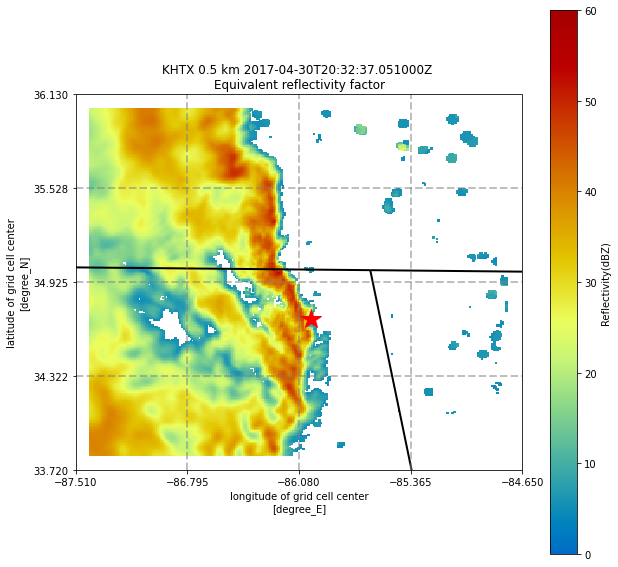

In [7]:
# Plot lowest level of radar grid
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('reflectivity_masked', 0, vmin=0, vmax=60, cmap='pyart_HomeyerRainbow', projection=projection)
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

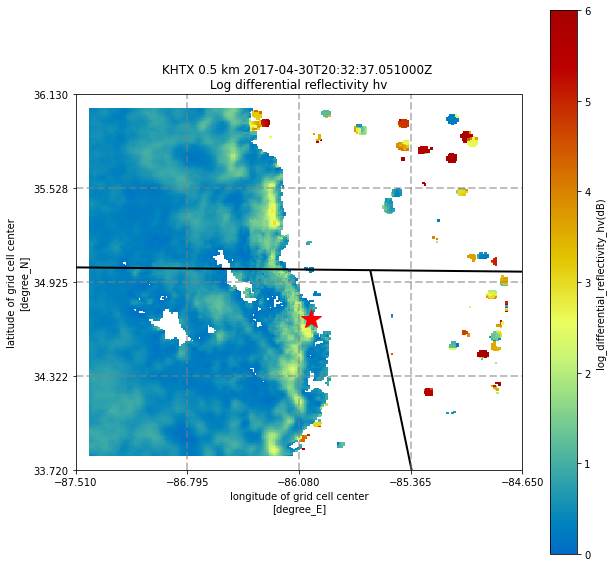

In [8]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('differential_reflectivity_masked', 0, vmin=0, vmax=6, cmap='pyart_HomeyerRainbow', projection=projection)
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

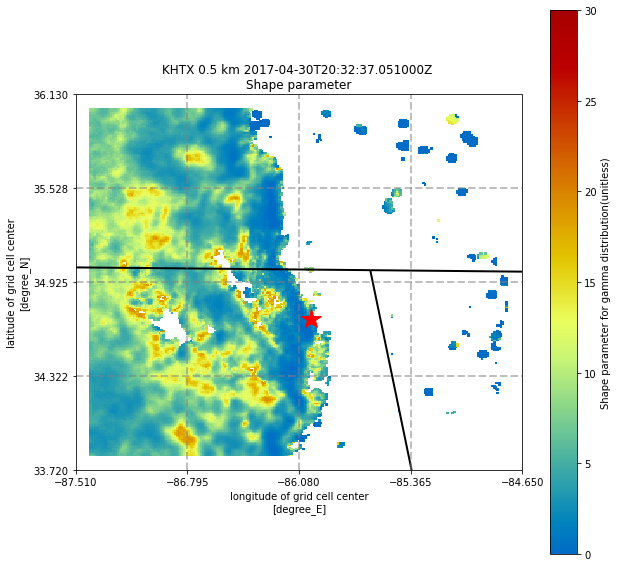

In [9]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('mu_Z01', 0, vmin=0, vmax=30, cmap='pyart_HomeyerRainbow', projection=projection)
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

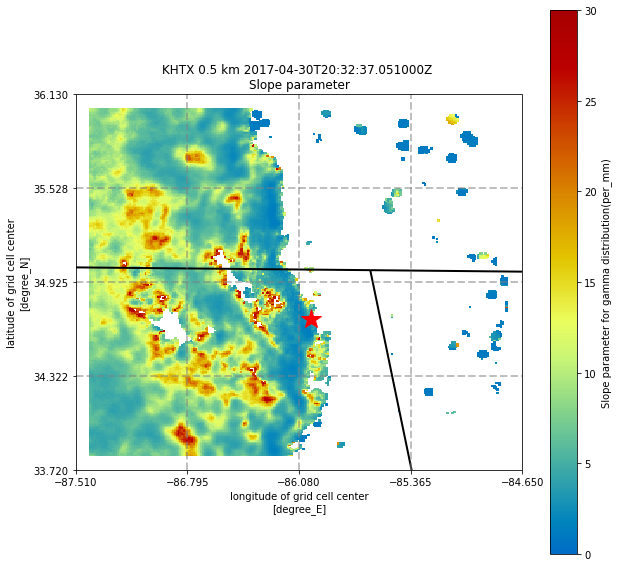

In [10]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('lamda_Z01', 0, vmin=0, vmax=30, cmap='pyart_HomeyerRainbow', projection=projection)
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

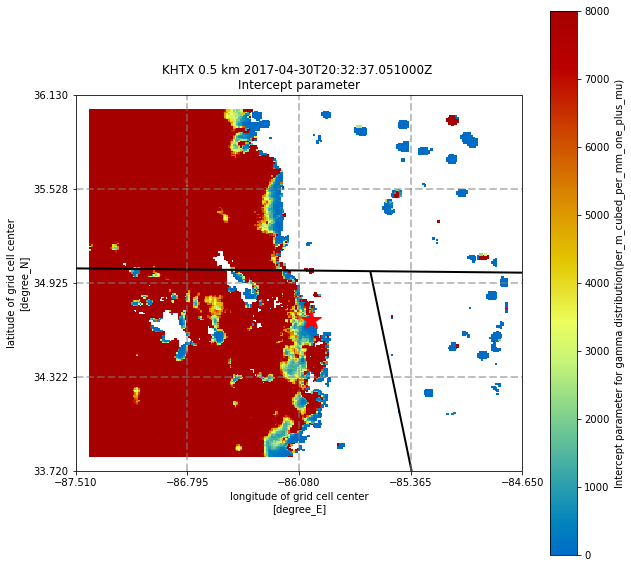

In [11]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('N0_Z01', 0, vmin=0, vmax=8.e3, cmap='pyart_HomeyerRainbow', projection=projection)
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

In [58]:
# Extract one level within a small bounding box for testing
lat_bgn = 34.3
lat_end = 35.0
lon_bgn = -86.5
lon_end = -85.75

# ibgn = 50
# iend = 150
# jbgn = 125
# jend = 225
# level = 2
# z_level = gridded_radar.point_z['data'][level, 0, 0]
z_level = 1000.
gridded_radar_xr = gridded_radar.to_xarray()
gridded_radar_xr = gridded_radar_xr.swap_dims({'y': 'lat', 'x': 'lon'})
gridded_radar_subgrid = gridded_radar_xr.sel(time='2017-04-30 20:32', 
                                             lat=slice(lat_bgn, lat_end), lon=slice(lon_bgn, lon_end), 
                                             z=z_level)
gridded_radar_subgrid = gridded_radar_subgrid.squeeze()
print(gridded_radar_subgrid)

<xarray.Dataset>
Dimensions:                           (lat: 76, lon: 68)
Coordinates:
    time                              object 2017-04-30 20:32:37.051000
    z                                 float64 1e+03
  * lat                               (lat) float64 34.31 34.31 ... 34.99 35.0
  * lon                               (lon) float64 -86.49 -86.48 ... -85.75
    y                                 (lat) float64 -6.868e+04 ... 8.2e+03
    x                                 (lon) float64 -3.792e+04 ... 3.075e+04
Data variables:
    differential_reflectivity         (lat, lon) float32 0.6234007 ... 1.9920238
    reflectivity                      (lat, lon) float32 13.009001 ... -6.648637
    cross_correlation_ratio           (lat, lon) float32 0.997964 ... 0.9024046
    ROI                               (lat, lon) float32 2104.3123 ... 883.3554
    reflectivity_masked               (lat, lon) float32 13.009001 ... nan
    differential_reflectivity_masked  (lat, lon) float32 0.6234007 .

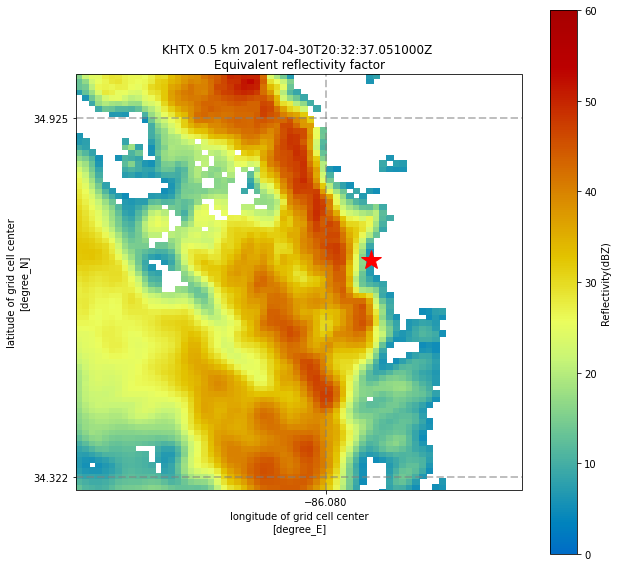

In [59]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=projection)
display = pyart.graph.GridMapDisplay(gridded_radar)
display.plot_grid('reflectivity_masked', 0, vmin=0, vmax=60, cmap='pyart_HomeyerRainbow', projection=projection)
ax.set_extent((lon_bgn, lon_end, lat_bgn, lat_end))
ax.plot([PIPS_lon], [PIPS_lat], 'r*', ms=20, transform=projection)

In [60]:
# Calculate ND for each grid point from gamma dist. parameters using Parsivel bins
avg_diameters = pp.parsivel_parameters['avg_diameter_bins_mm']
#avg_diameters = avg_diameters[:, np.newaxis, np.newaxis]
#avg_diameters = xr.DataArray(avg_diameters, dims=['diameter_bin', 'y', 'x'])
avg_diameters = xr.DataArray(avg_diameters, coords = {'diameter': ('diameter_bin', avg_diameters)}, 
                             dims=['diameter_bin'])

lamda = gridded_radar_subgrid['lamda_Z01'] * 1000. # get to m^-1
alpha = gridded_radar_subgrid['mu_Z01']
N0 = gridded_radar_subgrid['N0_Z01'] * 1000**(1 + alpha) # get to m^-4
ND = dsd.calc_binned_DSD_from_params(N0, lamda, alpha, avg_diameters) * 1.e-3 # Get to m^-3 mm^-1
ND.coords['max_diameter'] = ('diameter_bin', pp.parsivel_parameters['max_diameter_bins_mm'])
ND.coords['min_diameter'] = ('diameter_bin', pp.parsivel_parameters['min_diameter_bins_mm'])

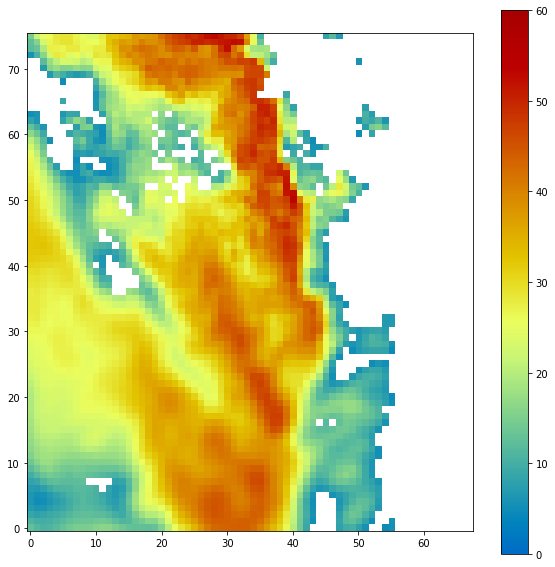

In [61]:
# Recompute Z from ND to check
dBZ_retr = dsd.calc_dBZ_from_bins(ND)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
dBZ = ax.imshow(dBZ_retr, origin='lower', vmin=0., vmax=60., cmap='pyart_HomeyerRainbow')
#dBZ = ax.contourf(dBZ_retr.coords['x'], dBZ_retr.coords['y'], dBZ_retr)
fig.colorbar(dBZ, ax=ax)

In [62]:
# Read in sounding file to get low-level wind field and then derive storm-relative wind
# Storm motion taken from subjective reflectivity tag tracking using GRLevel2
ustorm = 12.51
vstorm = 12.95
sounding_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/2017/soundings/COMP5mb'
sounding_filename = 'Hollywood_201704301954.cls'
sounding_path = os.path.join(sounding_dir, sounding_filename)
sounding_metadata, sounding_df = readESC(sounding_path)

Holl
["085 57.41'W", " 34 43.00'N", ' -85.957', ' 34.717', ' 189.0']


In [63]:
# Set up grid for precip trajectories

height_AGL_snd = sounding_df['height'] - sounding_metadata['selev']
# print(gridded_radar_subgrid['x'])
grid_height = gridded_radar_subgrid['z'].values
# grid_height = 2000.
# print(gridded_radar.origin_altitude)
dz = 1.
new_heights = np.arange(0., grid_height + dz, dz)

# Interpolate sounding u, v to new regularly spaced heights
u_snd = sounding_df['u'].values
f = interpolate.interp1d(height_AGL_snd, u_snd, bounds_error=False, fill_value=(u_snd[0], u_snd[-1]))
ug = f(new_heights)

v_snd = sounding_df['v'].values
f = interpolate.interp1d(height_AGL_snd, v_snd, bounds_error=False, fill_value=(v_snd[0], v_snd[-1]))
vg = f(new_heights)

# Storm-relative winds
usr = ug - ustorm
vsr = vg - vstorm

# Layer-mean storm-relative winds
usm = np.mean(usr)
vsm = np.mean(vsr)
print(usm, vsm)


-15.057314272999298 -3.2416033421006674


In [64]:
D_max = 9.
D_range_full = ND['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_range)
ND_trunc = ND.isel(diameter_bin=slice(0, D_max_ind))
vt_range = rain_Brandes(D_range / 1000.)
print(vt_range)

# Set dimensions back from lat/lon to y/x for ND_trunc
ND_trunc = ND_trunc.swap_dims({'lon': 'x', 'lat': 'y'})

# Interpolate ND to a finer grid
# Set up grid of locations
x_coords = ND_trunc['x']
y_coords = ND_trunc['y']

new_x_coords = np.linspace(x_coords.x[0], x_coords.x[-1], x_coords.sizes['x'] * 4)
new_y_coords = np.linspace(y_coords.y[0], y_coords.y[-1], y_coords.sizes['y'] * 4)

ND_trunc = ND_trunc.interp(x=new_x_coords, y=new_y_coords)

x_grid, y_grid = xr.broadcast(ND_trunc['x'], ND_trunc['y'])
x_flat = x_grid.stack(loc=['y', 'x']).values
y_flat = y_grid.stack(loc=['y', 'x']).values

# Compute horizontal deviations of drops at bottom of layer for each grid point and drop size
xf, yf = cal_xf(usm, vsm, vt_range, grid_height)
print(xf, yf)
x_flat_f = x_flat[:, np.newaxis] + xf
y_flat_f = y_flat[:, np.newaxis] + yf

[0.0625 0.1875 0.3125 0.4375 0.5625 0.6875 0.8125 0.9375 1.0625 1.1875
 1.375  1.625  1.875  2.125  2.375  2.75   3.25   3.75   4.25   4.75
 5.5    6.5    7.5    8.5   ]
[0.20243847 0.78959234 1.34827725 1.87939531 2.38383474 2.86246996
 3.31616154 3.7457562  4.15208682 4.53597247 5.07147419 5.71431825
 6.28142631 6.77868642 7.2117652  7.75289421 8.29872984 8.67865684
 8.92737921 9.07605796 9.17093988 9.17535487 9.16157188 9.20881488]
[-74379.70620577 -19069.73196263 -11167.81746699  -8011.78667781
  -6316.42538992  -5260.25232594  -4540.58528134  -4019.83297355
  -3626.44494446  -3319.53387824  -2969.02117845  -2635.01499398
  -2397.11707805  -2221.27317153  -2087.88193263  -1942.15397029
  -1814.41191251  -1734.98210122  -1686.64441346  -1659.01477688
  -1641.85072394  -1641.06069772  -1643.52956877  -1635.09794446] [-16012.78288077  -4105.41387011  -2404.2557503   -1724.81187549
  -1359.82720974  -1132.44973246   -977.51671754   -865.40692221
   -780.71665629   -714.64352267   -639.

<xarray.DataArray (y: 304, x: 272)>
array([[ 24.126958  ,  22.57398722,  21.02101644, ...,   0.        ,
          0.        ,   0.        ],
       [ 22.60470993,  21.14557881,  19.68644769, ...,   0.        ,
          0.        ,   0.        ],
       [ 21.08246185,  19.71717039,  18.35187893, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 18.30200109,  39.48815354,  60.67430598, ...,   0.        ,
          0.        ,   0.        ],
       [ 21.39177898,  51.0203504 ,  80.64892183, ...,   0.        ,
          0.        ,   0.        ],
       [ 24.48155687,  62.55254727, 100.62353767, ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
    time     object 2017-04-30 20:32:37.051000
    z        float64 1e+03
    lat      (y) float64 34.31 34.31 34.31 34.31 ... 34.99 34.99 34.99 35.0
    lon      (x) float64 -86.49 -86.49 -86.49 -86.49 ... -85.76 -85.75 -85.75
  * x        (x) float64 -3.792e+04 -3.767e+04 -3.742e+04 ... 3.05e+04 3.0

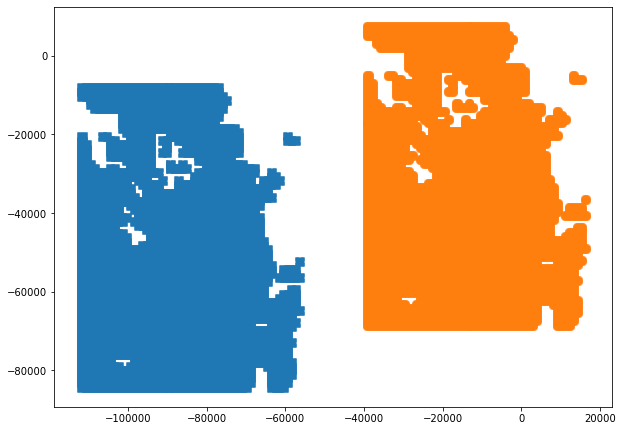

In [65]:
# Test plot of endpoints
Nt = ND_trunc.sum(dim='diameter_bin')
print(Nt)
Nt_flat = Nt.values.flatten()
indices = np.where(Nt_flat > 0.)[0]
x_flat_f_0 = x_flat_f[:, 0]
y_flat_f_0 = y_flat_f[:, 0]
x_flat_f_1 = x_flat_f[:, -1]
y_flat_f_1 = y_flat_f[:, -1]

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_flat_f_0[indices], y_flat_f_0[indices], marker='x')
ax.scatter(x_flat_f_1[indices], y_flat_f_1[indices], marker='o', alpha=0.5)
# ax.set_xlim(-40000., -30000.)
# ax.set_ylim(50000., 60000.)

ax.set_aspect('equal')

In [66]:
ND_trunc_2 = ND_trunc.transpose("y", "x", "diameter_bin")
ND_trunc_flat = ND_trunc_2.stack(loc=['y', 'x'])
ND_trunc_flat = ND_trunc_flat.transpose("loc", "diameter_bin")
ND_trunc_flat = ND_trunc_flat.where(ND_trunc_flat > 0., 0.)
ND_trunc_flat = ND_trunc_flat.where(np.isfinite(ND_trunc_flat), 0.0)

# Get polarimetric variables
dD = ND_trunc['max_diameter'] - ND_trunc['min_diameter']
print(dD)
dualpol_dict = dualpol.calpolrain(10.7, '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                  ND_trunc_flat, dD)
print(dualpol_dict['ZH_bin'])

# Get Rayleigh reflectivity for each precip trajectory endpoint
M6, M6_D_bins_flat = dsd.calc_moment_bin(ND_trunc_flat, moment=6)
# M6_D_bins = M6_D_bins.where(np.isfinite(M6_D_bins))
# M6_D_bins = M6_D_bins.transpose("y", "x", "diameter_bin")
# M6_D_bins_arr = M6_D_bins.values
# M6_D_bins_flat = M6_D_bins_arr.reshape(-1, M6_D_bins_arr.shape[-1])
#M6_D_bins_flat = M6_D_bins.stack(loc=['y', 'x'])
#print(M6_D_bins_flat)
M6_D_bins_flat = M6_D_bins_flat.transpose("loc", "diameter_bin")
dBZ_D_bins_flat = 10. * np.log10(1.e18 * M6_D_bins_flat)
dBZ_flat = 10. * np.log10(1.e18 * M6_D_bins_flat.sum(dim='diameter_bin'))
dBZ_D_bins_flat = dBZ_D_bins_flat.transpose("loc", "diameter_bin")
# dBZ_D_bins_flat = dBZ_D_bins_flat.where(np.isfinite(dBZ_D_bins_flat))

<xarray.DataArray (diameter_bin: 24)>
array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125,
       0.125, 0.25 , 0.25 , 0.25 , 0.25 , 0.25 , 0.5  , 0.5  , 0.5  ,
       0.5  , 0.5  , 1.   , 1.   , 1.   , 1.   ])
Coordinates:
    time          object 2017-04-30 20:32:37.051000
    z             float64 1e+03
    diameter      (diameter_bin) float64 0.0625 0.1875 0.3125 ... 6.5 7.5 8.5
    max_diameter  (diameter_bin) float64 0.125 0.25 0.375 0.5 ... 7.0 8.0 9.0
    min_diameter  (diameter_bin) float64 0.0 0.125 0.25 0.375 ... 6.0 7.0 8.0
Dimensions without coordinates: diameter_bin
<xarray.DataArray (loc: 82688, diameter_bin: 24)>
array([[1.01263837e-11, 7.24360224e-07, 8.69723872e-05, ...,
        5.92623692e-06, 5.60220571e-08, 4.02775245e-10],
       [8.92793046e-12, 6.58554729e-07, 8.01578155e-05, ...,
        5.00575449e-06, 4.65276646e-08, 3.29597844e-10],
       [7.72947720e-12, 5.92749233e-07, 7.33432438e-05, ...,
        4.08527206e-06, 3.70332721e-08, 2.5642044

In [67]:
# Set up 2D bins for bottom of sorting layer

dx_bins = 500.
dx_orig = new_x_coords[1] - new_x_coords[0]
print("dx (top), dx (bottom)", dx_orig, dx_bins)
area_ratio = dx_bins**2. / dx_orig**2.
print("area ratio: ", area_ratio)
# Get bounding box of bottom of domain
xmin = int(x_flat_f.min()) # -5000.
xmax = int(x_flat_f.max())
ymin = int(y_flat_f.min()) # -5000.
ymax = int(y_flat_f.max())

# Create bins for bottom of domain
xbins = int((xmax-xmin)/dx_bins)
ybins = int((ymax-ymin)/dx_bins)

print(xbins)
print(ybins)
xmax = xmin+dx_bins*xbins # +5000.
ymax = ymin+dx_bins*ybins # +5000.
print(xmin, xmax, ymin, ymax)

dx (top), dx (bottom) 253.41328413283918 500.0
area ratio:  3.892971768255312
282
185
-112304 28696.0 -84687 7813.0


In [68]:
# Create 2D histogram of Z and ZDR for endpoints of drop trajectories

ZH_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
                                         bins=[xbins, ybins],
                                         range=[[xmin, xmax], [ymin, ymax]],
                                         weights=dualpol_dict['ZH_bin'].values.flatten())

ZV_bins, xedges, yedges = np.histogram2d(x_flat_f.flatten(), y_flat_f.flatten(),
                                         bins=[xbins, ybins],
                                         range=[[xmin, xmax], [ymin, ymax]],
                                         weights=dualpol_dict['ZV_bin'].values.flatten())

# Need to scale by the area ratio between the top and bottom grids
ZH_bins = ZH_bins / area_ratio
ZV_bins = ZV_bins / area_ratio

dBZBin = 10. * np.log10(ZH_bins)
ZDRBin = 10. * np.log10(ZH_bins / ZV_bins)

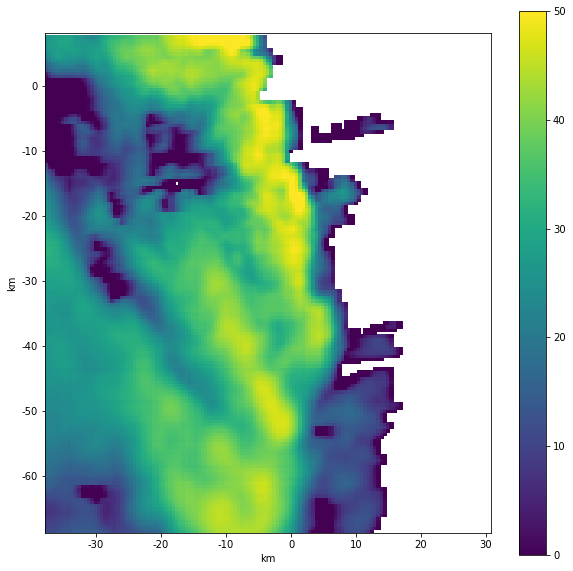

In [69]:
# Plot Z at bottom of layer after binning precip trajectory endpoints

fig, ax = plt.subplots(figsize=(10, 10))
plotvarBin = dBZBin 

clevels = np.arange(0., 55., 5.)
vmin = clevels[0]
vmax = clevels[-1]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
# plotvarBin = np.ma.masked_invalid(plotvarBin)
# plotvarBin = np.ma.masked_outside(plotvarBin, vmin, vmax)
    #plot=ax.pcolormesh(xedges,yedges,DmperBin.T,vmin=vmin,vmax=vmax,cmap=cm.jet,norm=norm,edgecolors='None',antialiased=False,rasterized=False)
plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, norm=norm, edgecolors='None',
                   antialiased=False, rasterized=False)
# plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, edgecolors='None',
#                    antialiased=False, rasterized=False)

fig.colorbar(plot, ax=ax)

formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.set_xlim(x_flat.min(), x_flat.max())
ax.set_ylim(y_flat.min(), y_flat.max())
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

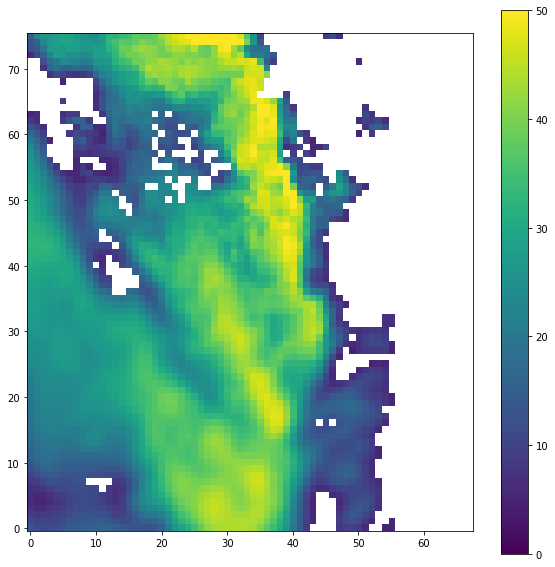

In [70]:
# Plot original reflectivity at the top of the grid for comparison and sanity check

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=0., vmax=50., clip=False)
dBZ = ax.imshow(gridded_radar_subgrid['reflectivity_masked'], origin='lower', vmin=0., vmax=50., norm=norm)
fig.colorbar(dBZ, ax=ax)

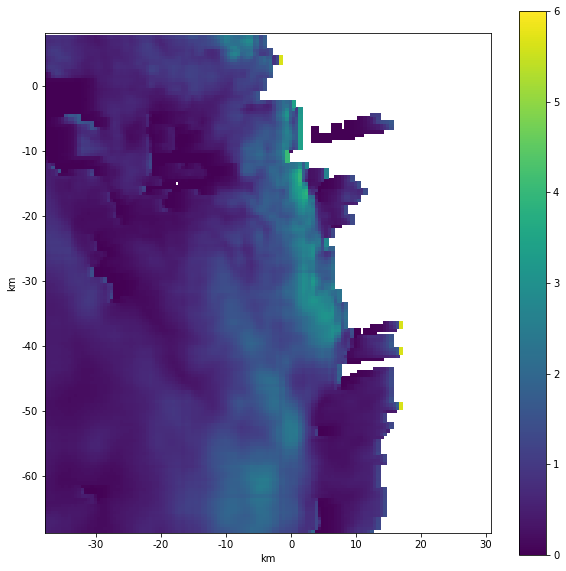

In [71]:
# Now do the same for ZDR

fig, ax = plt.subplots(figsize=(10, 10))
plotvarBin = ZDRBin 

clevels = np.arange(0., 6.1, 0.1)
vmin = clevels[0]
vmax = clevels[-1]
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=False)
# plotvarBin = np.ma.masked_invalid(plotvarBin)
# plotvarBin = np.ma.masked_outside(plotvarBin, vmin, vmax)
    #plot=ax.pcolormesh(xedges,yedges,DmperBin.T,vmin=vmin,vmax=vmax,cmap=cm.jet,norm=norm,edgecolors='None',antialiased=False,rasterized=False)
plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, norm=norm, edgecolors='None',
                   antialiased=False, rasterized=False)
# plot=ax.pcolormesh(xedges, yedges, plotvarBin.T, cmap=cm.viridis, edgecolors='None',
#                    antialiased=False, rasterized=False)

fig.colorbar(plot, ax=ax)

formatter = ticker.FuncFormatter(mtokm)
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=10000.))
ax.set_xlim(x_flat.min(), x_flat.max())
ax.set_ylim(y_flat.min(), y_flat.max())
ax.set_xlabel('km')
ax.set_ylabel('km')
ax.set_aspect('equal')

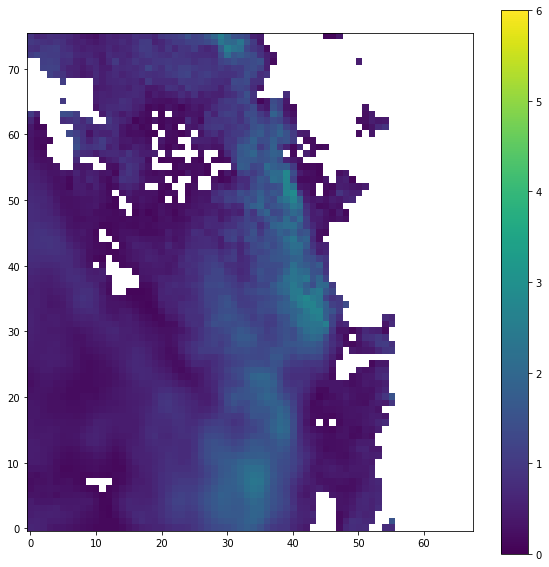

In [72]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
norm = matplotlib.colors.Normalize(vmin=0., vmax=6., clip=False)
ZDR = ax.imshow(gridded_radar_subgrid['differential_reflectivity_masked'], origin='lower', vmin=0., vmax=6., 
                norm=norm)
fig.colorbar(ZDR, ax=ax)